In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["LANGSMITH_PROJECT"]="Explore LangGraph"
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"

In [3]:
llm = ChatOpenAI(model="gpt-4o")

In [4]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [5]:
@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b
tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}

In [6]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

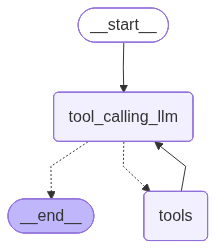

In [7]:
graph

In [8]:
response=graph.invoke({"messages":"What is machine learning?"})
response

{'messages': [HumanMessage(content='What is machine learning?', additional_kwargs={}, response_metadata={}, id='d5265b82-18cb-482a-8c15-41581b79cd7e'),
  AIMessage(content='Machine learning is a branch of artificial intelligence (AI) that involves the development of algorithms and statistical models that enable computers to perform tasks without explicit instructions. Instead of being directly programmed, machine learning systems learn from data input, allowing them to identify patterns, make decisions, and improve over time with experience. The goal is to enable computers to learn and make decisions based on data, enhancing their ability to predict outcomes or classify information.\n\nKey components of machine learning include:\n\n1. **Data Input**: Vast amounts of data are used to train machine learning models. This data can be structured (like databases) or unstructured (like images or text).\n\n2. **Algorithms**: These are the mathematical models used to analyze data and identify p

In [9]:
response1=graph.invoke({"messages":"what is 5 plus 20"})
response1

{'messages': [HumanMessage(content='what is 5 plus 20', additional_kwargs={}, response_metadata={}, id='fabbc634-becc-4437-8458-e52d2967d520'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9gKHwRnjhcJ6MyNQMRPlp2zx', 'function': {'arguments': '{"a":5,"b":20}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 51, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-CLyQSJBVbHKJUNLk8X2gmacceenMW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d039864b-0a33-4562-92c3-c8b2b77299b9-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 20}, 'id': 'call_9gKHwRnjhcJ6MyNQMRPlp2zx', 'type': 